# Thesis Data Analysis

In [290]:
# read .csv
from svglib.svglib import svg2rlg

# computation & data structures
import numpy as np
from numpy import radians as rd
from numpy import degrees as dg
from numpy import sin, cos, tan, arcsin, arccos, arctan, arctan2, abs, mean
import itertools
import pandas as pd
from typing import Callable
import glob

# plots
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.graphics import renderPDF
import os
import shutil
from dataclasses import dataclass, field

import time

## Map Output Analysis

This cell handles the GIS output. Most of the attributes have already been calculated, so the main purpose of this code is to examine subsets of the data (center points, sample locations, distances) and evaluate each inflation center by a few different criteria (fraction of data explainable, fraction explainable within certain tilt constraints, etc.).

In [118]:
MARS_EQ_RADIUS = 3396.2  # km


def dist(lat, lon, latC, lonC):
    lat = rd(lat)
    lon = rd(lon)
    latC = rd(latC)
    lonC = rd(lonC)
    rads = arccos(
        cos(lat) * cos(latC)
        * cos(lonC - lon)
        + sin(lat) * sin(latC)
    )
    return rads * MARS_EQ_RADIUS


def bearing(lat, lon, latC, lonC):
    lat = rd(lat)
    lon = rd(lon)
    latC = rd(latC)
    lonC = rd(lonC)
    y = sin(lonC - lon) * cos(latC)
    x = cos(lat) * sin(latC) \
        - sin(lat) * cos(latC) * cos(lonC - lon)
    return (180 + dg(arctan2(y, x))) % 360


def beta(az, bearing):
    return az-bearing


def sl1(beta1, beta2, sl2):
    beta1 = rd(beta1)
    beta2 = rd(beta2)
    sl2 = rd(sl2)
    arg = sin(beta2) * sin(sl2) / sin(beta1)
    if arg < 0 or arg > 1:  # not possible
        return np.nan
    else:
        sl1 = arcsin(arg)
        return dg(sl1)


def proj(beta, sl):
    beta = rd(beta)
    sl = rd(sl)
    proj = arctan(tan(beta) * cos(beta))
    return dg(proj)


def tilt(beta1, sl1, beta2, sl2):
    return proj(beta2, sl2) - proj(beta1, sl1)

In [119]:
test_beta = beta(
    az=-5,
    bearing=50
)
test_beta

-55

In [214]:
# location to read .csv files
map_path = "../GEOL192-GIS/data/"


centers = pd.read_csv(f'{map_path}centers.csv').set_index('cID')
samples = pd.read_csv(f'{map_path}samples.csv').set_index(['sID', 'FEATURE'])

cIDs = tuple(centers.index)
sIDs = tuple(index[0] for index in samples.index)

samples

,,LAT,LON,AZ1,SL2,AZ2
sID,FEATURE,,,,,
1,channel,16.880595,-131.903603,138.236797,10.177755,134.840515
2,channel,16.930464,-131.979965,141.438327,7.755409,138.883377
3,channel,16.888972,-131.956341,141.438327,10.547471,150.837128
4,channel,16.847806,-131.926314,141.438327,8.095935,132.273743
5,channel,16.869367,-131.876955,152.243284,8.960983,138.420624
...,...,...,...,...,...,...
561,flow,16.580752,-132.143970,141.459287,2.089160,140.594315
562,flow,16.545437,-132.108797,141.459287,4.008940,150.214874
563,flow,16.498404,-132.090502,141.459287,4.635088,152.368897


This cell defines an object to organize the data from a single .csv file (corresponding to a single candidate center point).

In [227]:
@dataclass
class FullCenter:
    cID: int

    def __post_init__(self):
        self.data = samples.copy()

        # this of course only works for unique self.cIDs
        self.latC = centers.loc[self.cID, 'LAT']
        self.lonC = centers.loc[self.cID, 'LON']
        self.calculate()

    def calculate(self):

        self.data['DIST'] = self.data.apply(
            lambda row: dist(
                lat=row['LAT'], lon=row['LON'],
                latC=self.latC, lonC=self.lonC
            ),
            axis=1
        )

        self.data['BEARING'] = self.data.apply(
            lambda row: bearing(
                lat=row['LAT'], lon=row['LON'],
                latC=self.latC, lonC=self.lonC
            ),
            axis=1
        )

        self.data['BETA1'] = self.data.apply(
            lambda row: beta(
                az=row['AZ1'], bearing=row['BEARING']
            ),
            axis=1
        )

        self.data['BETA2'] = self.data.apply(
            lambda row: beta(
                az=row['AZ2'], bearing=row['BEARING']
            ),
            axis=1
        )

        self.data['SL1'] = self.data.apply(
            lambda row: sl1(
                beta1=row['BETA1'],
                beta2=row['BETA2'], sl2=row['SL2']
            ),
            axis=1
        )

        self.data['TILT'] = self.data.apply(
            lambda row: tilt(
                beta1=row['BETA1'], sl1=row['SL1'],
                beta2=row['BETA2'], sl2=row['SL2']
            ),
            axis=1
        )


# each analysis takes about .05 seconds (40 s total)
centers_calc = [FullCenter(cID) for cID in cIDs]

17.06617605
-133.3827624


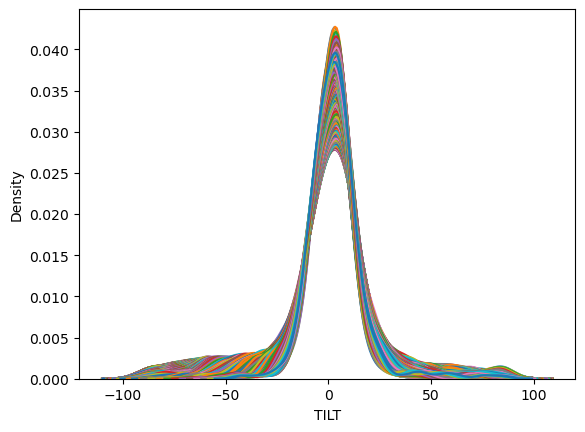

In [145]:
print(centers_calc[1].latC)
print(centers_calc[1].lonC)
# centers[1].data['SL1'][centers[1].data['SL1'].isnull()]
# centers[1].data
# sns.scatterplot(data=centers[100].data,x='DIST',y='TILT')
for center in centers_calc:
    sns.kdeplot(x=center.data['TILT'])

## Populations (Subsets)

In [351]:
@dataclass
class Population:
    feature: tuple = ('flow', 'channel')
    name: str = ''
    sIDs: tuple = sIDs  # type: ignore


pops = [
    Population(),
    Population(('flow',)),
    Population(('channel',)),
    # these are wrong, will have to look for point IDs or go back to get linear feature Ids to inherit into samples.
    # Population(('flow',), 'SE', (49, 60, 61, 62, 63, 64, 85, 86, 87))
]

## Criteria

In [352]:
def summit_score(center: FullCenter, pop: Population):
    df = center.data
    subset_beta1 = df.loc[(pop.sIDs, pop.feature), 'BETA1']
    return mean(abs(subset_beta1))


@dataclass
class Criterion:
    func: Callable
    name: str


criteria = [Criterion(summit_score, 'summit_score')]  # needs to be an iterable

In [385]:
def evaluate(center: FullCenter, pop: Population, criterion: Callable) -> float:
    return criterion(center, pop)

full_dict = {}
score_name_list = []

for pop in pops:
    for crit in criteria:
        name = f'{pop.feature}_{pop.name}_{crit.name}'
        name = name.replace("__", "_")
        name = name.replace("(", "")
        name = name.replace(")", "")
        name = name.replace(",", "")
        name = name.replace("'", "")
        name = name.replace("flow channel_", "")
        score_name_list.append(name)

for center in centers_calc:
    cID = center.cID
    center_list = []
    for pop in pops:
        for crit in criteria:
            center_list.append(evaluate(center, pop, crit.func))
    full_dict[center.cID] = center_list

centers_eval = pd.DataFrame(full_dict).transpose().set_axis(score_name_list, axis=1)
centers = pd.concat((centers, centers_eval), axis=1)
centers

,LAT,LON,summit_score,flow_summit_score,channel_summit_score,summit_score,flow_summit_score,channel_summit_score,summit_score,flow_summit_score,...,channel_summit_score,summit_score,flow_summit_score,channel_summit_score,summit_score,flow_summit_score,channel_summit_score,summit_score,flow_summit_score,channel_summit_score
1,17.066176,-133.449093,50.274971,66.457005,43.485023,50.274971,66.457005,43.485023,50.274971,66.457005,...,43.485023,50.274971,66.457005,43.485023,50.274971,66.457005,43.485023,50.274971,66.457005,43.485023
2,17.066176,-133.382762,49.675932,66.351033,42.679093,49.675932,66.351033,42.679093,49.675932,66.351033,...,42.679093,49.675932,66.351033,42.679093,49.675932,66.351033,42.679093,49.675932,66.351033,42.679093
3,17.066176,-133.316431,49.119740,66.331817,41.897587,49.119740,66.331817,41.897587,49.119740,66.331817,...,41.897587,49.119740,66.331817,41.897587,49.119740,66.331817,41.897587,49.119740,66.331817,41.897587
4,17.066176,-133.250100,48.655482,66.408739,41.206251,48.655482,66.408739,41.206251,48.655482,66.408739,...,41.206251,48.655482,66.408739,41.206251,48.655482,66.408739,41.206251,48.655482,66.408739,41.206251
5,17.066176,-133.183769,48.207107,66.592972,40.492435,48.207107,66.592972,40.492435,48.207107,66.592972,...,40.492435,48.207107,66.592972,40.492435,48.207107,66.592972,40.492435,48.207107,66.592972,40.492435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,18.823452,-133.108628,NaN,NaN,NaN,NaN,NaN,NaN,28.333264,37.970292,...,24.289587,28.333264,37.970292,24.289587,28.333264,37.970292,24.289587,28.333264,37.970292,24.289587
778,18.823452,-133.041634,NaN,NaN,NaN,NaN,NaN,NaN,26.178799,30.694379,...,24.284070,26.178799,30.694379,24.284070,26.178799,30.694379,24.284070,26.178799,30.694379,24.284070
779,18.823452,-132.974641,NaN,NaN,NaN,NaN,NaN,NaN,26.426610,31.323372,...,24.371939,26.426610,31.323372,24.371939,26.426610,31.323372,24.371939,26.426610,31.323372,24.371939
780,18.823452,-132.907648,NaN,NaN,NaN,NaN,NaN,NaN,26.898157,32.354870,...,24.608531,26.898157,32.354870,24.608531,26.898157,32.354870,24.608531,26.898157,32.354870,24.608531


<Axes: xlabel='LON', ylabel='LAT'>

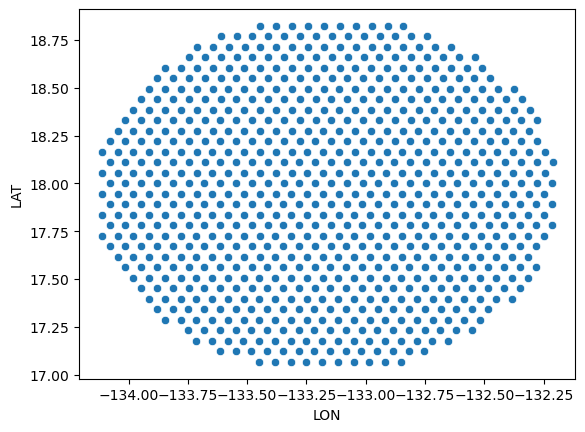

In [384]:
sns.scatterplot(data=centers, y='LAT', x='LON')

The old way where everything was calculated in GIS ModelBuilder...

In [5]:
# def map_data_from_csv(feature, num) -> pd.DataFrame:
#     '''read GIS attribute table exports'''
#     return pd.read_csv(f"{map_data_location}{feature}_{str(num)}.csv")

# flow_filenames = glob.glob(map_data_location + "flow*.csv")
# channel_filenames = glob.glob(map_data_location + "channel*.csv")

@dataclass
class Center:
    cID: int
    pop: Population

    def __post_init__(self):

        # read data and take subset if passed
        self.data = map_data_from_csv(self.pop.feature, self.cID)
        if self.pop.sIDs is not None:
            self.data = self.data.loc[self.data['ORIG_FID'].isin(self.pop.sIDs)]

        # calculate beta1 for summit score. I know this is ridiculous
        self.data['BETA1'] = self.data.apply(
            lambda row:
                dg(arccos(cos(rd(row['AZ1'] - row['THETA'])))), axis=1
        )

        # define a criterion for realistic tilt. TODO: make f(dist)
        MAX_TILT = 5

        def inflation_is_realistic(df) -> list:
            return abs(df['TILT']) < MAX_TILT

        self.data_realistic_inflation = self.data[inflation_is_realistic(
            self.data)]

        # correct distances to km and add other key attributes to object
        self.dist = self.data['DIST'] / 1000
        self.tilt = self.data['TILT']
        self.beta1 = self.data['BETA1']

        # correct distances to km and add other key attributes to object
        self.dist_realistic = self.data_realistic_inflation['DIST'] / 1000
        self.tilt_realistic = self.data_realistic_inflation['TILT']

        self.evaluate()

    def evaluate(self):
        self.full_name = f'{self.pop.feature}_{self.pop.name}'
        self.criteria = {
            'ID': self.cID,
            f'frac_possible_{self.full_name}':
                self.data['TILT'].notnull().sum() / len(self.data),
            f'frac_realistic_{self.full_name}':
                self.data_realistic_inflation['TILT'].notnull(
                ).sum() / len(self.data),
            f'summit_score_{self.full_name}':
                mean(abs(self.data['BETA1'])),
        }

This cell makes a single .csv to evaluate performance of each center on each of the criteria and each of the sample populations. 

In [6]:
# 2D array. outer list is of center points. inner lists are of Center objects for feature populations
data_array = [[Center(ID, pop) for pop in pops] for ID in cIDs]

centers_eval = pd.DataFrame(
    [dict([(attr, val) for pop in center for attr, val in pop.criteria.items()]) for center in data_array])

channel_samples = 401
flow_samples = 167
num_total = channel_samples + flow_samples

flow_weight = flow_samples / num_total
channel_weight = channel_samples / num_total

# add a combined score (both channel and flow data) to the df


def weight_avg_score(score: str):
    centers_eval[f'{score}_combined'] = centers_eval.apply(
        lambda row:
            flow_weight * row[f'{score}_flow_ALL'] +
            channel_weight * row[f'{score}_channel_ALL'],
            axis=1
    )


weight_avg_score('summit_score')
weight_avg_score('frac_possible')
weight_avg_score('frac_realistic')

centers_eval.to_csv(f'{map_path}centers_eval.csv')

## Model Output Analysis

Then, I define functions for reading the starting positions and displacements (radial and vertical components) of mesh vertices as expressed in the COMSOL files.

In [7]:
model_data_location = "../GEOL192-Model/data/"

topo = np.genfromtxt(f'{model_data_location}z1.csv', delimiter=",")


def model_pos1_from_csv(name: str):
    r = np.genfromtxt(model_data_location + "r_" + name, delimiter=",")[:, 0]
    z = np.interp(r, *topo.T, right=0)
    return np.array([r, z]).T


def model_disp_from_csv(name: str):
    r = np.genfromtxt(f'{model_data_location}r_{name}', delimiter=",")[:, 1]
    z = np.genfromtxt(f'{model_data_location}z_{name}', delimiter=",")[:, 1]
    return np.array([r, z]).T

I define physical constants used in the model here:

In [15]:
# constants in SI units
SHEAR_MODULUS = 2.4e10
ROCK_DENSITY = 2700
MAGMA_DENSITY = 2700
MARS_GRAVITY = 3.72
PLOT_WIDTH = 200_000


I include functions for displacement and angular tilt from an analytical solution which assumes a elastic half-space inflated by a spherical reservoir, for comparison as appropriate.

In [16]:
@dataclass
class MogiModel:
    dP: float
    radius: float
    DtC: float
    r1: np.array # type: ignore

    def disp(self) -> np.array: # type: ignore
        common = 3 * self.radius**3 * self.dP / \
            (4 * SHEAR_MODULUS * (self.DtC**2 + self.r1**2)**1.5)
        rdisp = common * self.r1
        zdisp = common * self.DtC
        return np.array(rdisp, zdisp)

    def tilt(self) -> np.array: # type: ignore
        a = 3 * self.radius**3 * self.dP / (4 * SHEAR_MODULUS)
        num = 3 * a * self.DtC * self.r1
        denom = (self.DtC**2 + self.r1**2)**2.5 + \
            a * self.DtC**2 - 2 * a * self.r1**2
        return dg(arctan2(num, denom))

Then I define classes for displaced vertices and surface elements (the latter defined by a consecutive pair of the former). These classes are primarily used to handle the radial tilt calculation.

In [17]:
@dataclass
class Vertex:
    pos1: tuple  # (r1, z1)
    disp: tuple  # (Ur, Uz)

    def __post_init__(self):
        self.pos2 = self.pos1 + self.disp


@dataclass
class Element:
    proximal: Vertex  # (A in text)
    distal: Vertex  # (B in text)

    def __post_init__(self):
        # relative dimensions [r, z] of initial and displaced segments
        self.shape1 = self.distal.pos1 - self.proximal.pos1 # type: ignore
        self.shape2 = self.distal.pos2 - self.proximal.pos2 # type: ignore

        # mean position of initial and displaced segments
        self.pos1 = (self.distal.pos1 + self.proximal.pos1) / 2 # type: ignore
        self.pos2 = (self.distal.pos2 + self.proximal.pos2) / 2 # type: ignore

        # radial distances for plotting
        self.r1_km = self.pos1[0] / 1000
        self.r2_km = self.pos2[0] / 1000

        # initial and displaced slopes (positive downward from center)
        # index [1] is z component; [0] is r component
        self.slope1 = dg(arctan2(-self.shape1[1], self.shape1[0]))
        self.slope2 = dg(arctan2(-self.shape2[1], self.shape2[0]))

        self.tilt = self.slope2 - self.slope1


Finally, a model class is initialized by a combination of parameters (geometry, overpressure) which reads the relevant .csv files, builds the vertices and elements, and converts the element attributes (position, displacement, tilt) into lists for plotting or further analysis.

In [18]:
class Model:
    def __init__(self, params: dict):

        self.params = params

        self.dP = params['pmult'] * params['DtT'] * ROCK_DENSITY * MARS_GRAVITY

        filename = f"DtT_{params['DtT']}_resr_{params['resr']}_pmult_{params['pmult']}_gmult_{params['grav']}_zmult_{params['topo']}_resaspect_{params['aspect']}.csv"

        # read initial positions and displacements
        self.pos1 = model_pos1_from_csv(filename)
        self.disp = model_disp_from_csv(filename)

        # subtract out gravitational component (with no overpressure)
        if params['grav']:
            filename_p0 = filename.replace(
                f"pmult_{params['pmult']}", "pmult_0")
            self.disp -= model_disp_from_csv(filename_p0)

        # make z1 flat for flat model
        if not params['topo']:
            self.pos1[1] = np.zeros(len(self.pos1[1]))

        # build vertices from pos1 and disp if pos1 within defined length
        self.num_vertices = next(i for i, val in enumerate(
            self.pos1) if val[0] > PLOT_WIDTH)
        self.vertices = [Vertex(self.pos1[i], self.disp[i])
                         for i in range(self.num_vertices)]

        # build elements from consecutive vertex pairs
        self.vertex_pairs = zip(self.vertices[:-1], self.vertices[1:])
        self.elements = [Element(*pair) for pair in self.vertex_pairs]

        # put element attributes into dict of lists
        self.attributes = pd.DataFrame(
            [vars(element) for element in self.elements]).to_dict("list")

        if params['aspect'] == 1:
            self.mogi_tilt = MogiModel(
                dP=self.dP,
                radius=params['resr'],
                DtC=params['DtT'] + params['resr'],
                r1=self.attributes['r1_km']).tilt()

# Model Output Analysis

I define the model parameter combinations used in COMSOL and build a Model class (defined above) from each geometry. Any subset of geometries can be used by removing elements from the parameter sets.

In [19]:
# parameter sweep in SI units (to match csv output from COMSOL)
class ParamSweep:
    def __init__(self, params: dict):

        # define constant parameters for labelling once in title
        self.constants = {key: val[0]
                          for key, val in params.items() if len(val) == 1}

        # define variable parameters for labelling individually
        self.variables = [key for key, val in params.items() if len(val) > 1]

        self.models = [Model(dict(zip(params, item)))
                       for item in itertools.product(*params.values())]

    def plot(self, name: str = None): # type: ignore
        fig = plt.figure(figsize=(8, 5), dpi=600)

        for model in self.models:
            sns.lineplot(data=model.attributes, y="tilt", x="r2_km", label={
                         param: model.params[param] for param in self.variables})

        plt.title(f"Radial Tilt: {self.constants}")
        plt.xlabel("Distance (km)")
        plt.ylabel("Tilt (dg)")
        plt.legend(loc="upper right")

        # save plot with name if passed as argument
        if name is not None:
            fig.savefig("plot.svg")
            renderPDF.drawToFile(svg2rlg("plot.svg"), f"figures/{name}.pdf")
            os.remove("plot.svg")


test_sweep = ParamSweep({
    "DtT": [12_000],  # 10_000
    "resr": [30_000],
    "aspect": [.5],
    "pmult": [0.6],
    "grav": [0],  # 0, 1
    "topo": [1]  # 0, 1
})

full_sweep = ParamSweep({
    "DtT": [14_000],  # 10_000
    "resr": [30_000],
    "aspect": [.5],
    "pmult": [0.2, 0.6],
    "grav": [0],
    "topo": [1]
})

# Plotting

Finally, I plot numerical model outputs:

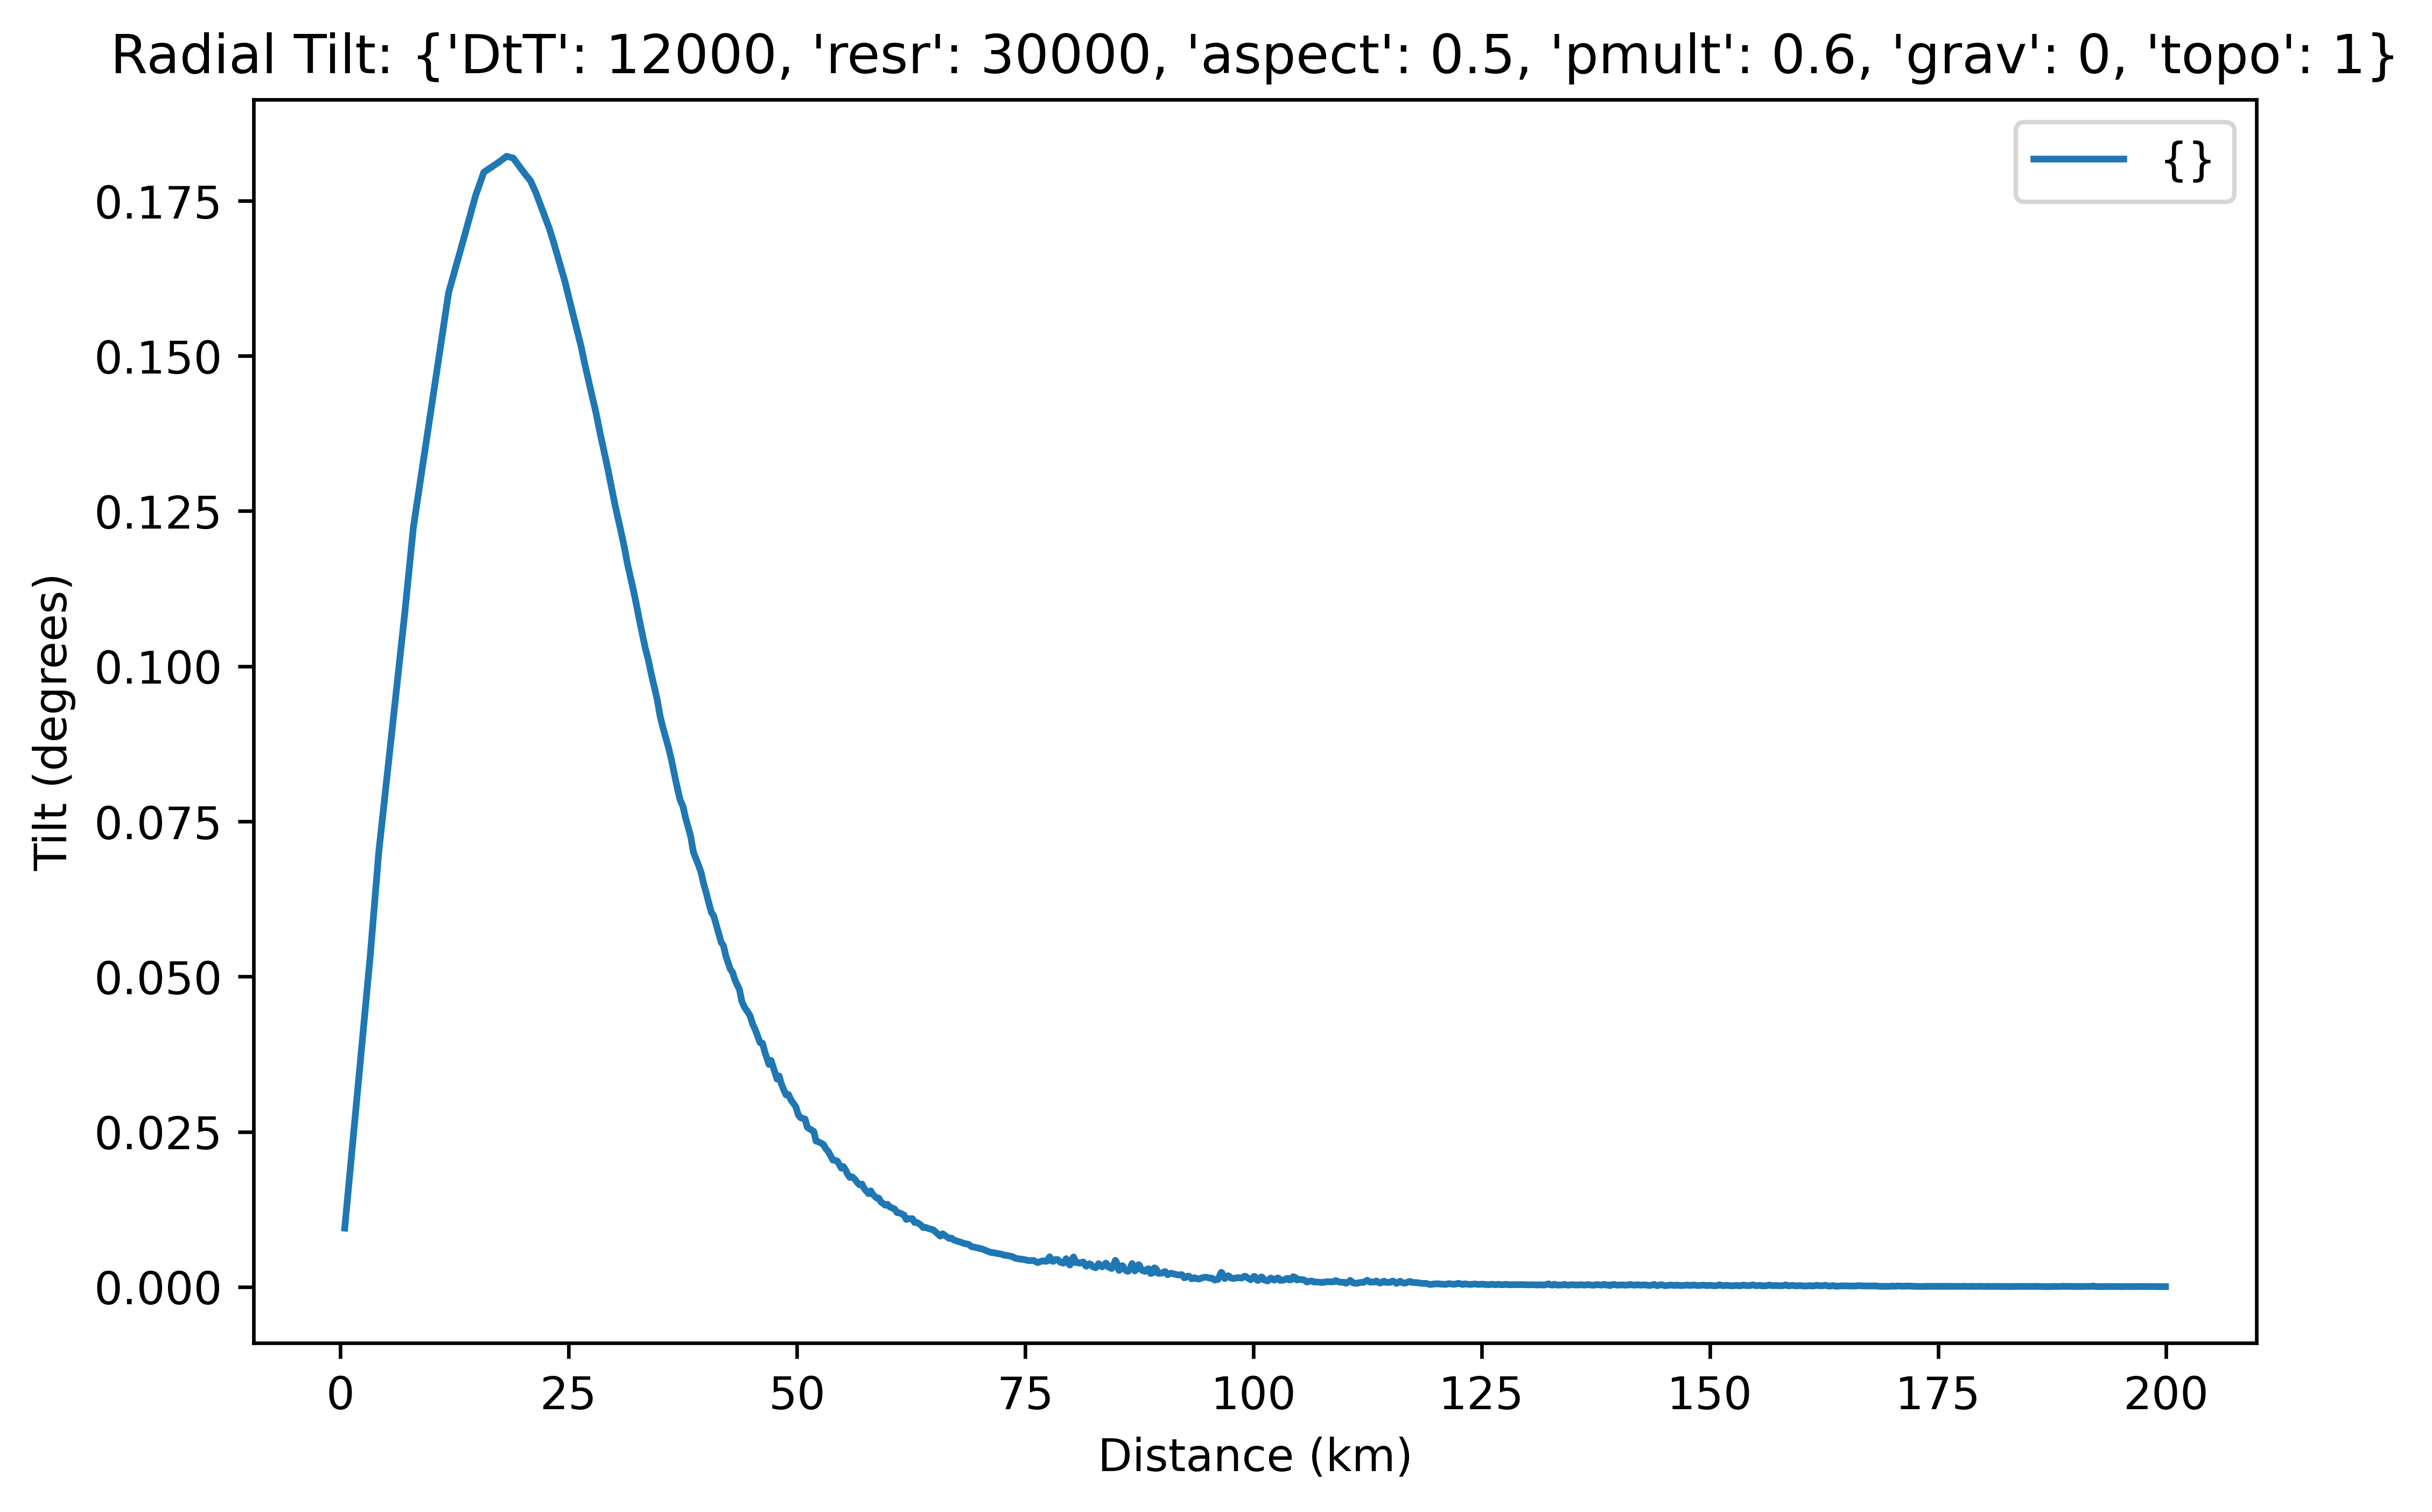

In [18]:
test_sweep.plot()